In [1]:
import json
import pandas as pd
import numpy as np
import string
import os
from sklearn.metrics.pairwise import cosine_similarity

## Load Data

#### Loading Question-Answer data

In [2]:
filename = "D:\\WebScience\\web_science_dataset.jsonl"
json_data = []
json_data_list = []


with open(filename) as f:
    json_data = f.readlines()
    
for item in json_data:
    json_data_list.append(json.loads(item))
    
df = pd.DataFrame(json_data_list)
df.head()

question_df = pd.DataFrame(df[['question','questionId','category','categoryId']])
question_df.head()

,question,questionId,category,categoryId
0,Can headbanging cause brain damage?,14138,medical-science,2
1,Does the Shangri-La diet work (according to it...,10103,nutrition,0
2,"Can phobias be genetic, but created in one gen...",18713,psychology,4
3,Do 40% of U.S. Americans think that global war...,36010,climate-change,1
4,Does boiling the same water twice make it dang...,11118,nutrition,0


In [3]:
train_file = "recommender_train.tsv"
test_file = "recommender_test.tsv"
train = pd.read_csv(train_file,delimiter="\t")
test =  pd.read_csv(test_file,delimiter="\t")

In [4]:
train.head()
train

,userID,questionID,rating
0,5205,17488,2
1,5205,8080,2
2,5205,36393,2
3,5205,44399,2
4,5205,44167,2
...,...,...,...
2339,5432,8054,1
2340,5432,17594,2
2341,5432,22562,2
2342,5432,22250,2


In [5]:
test.head()
test.dtypes

userID         int64
questionID     int64
recommend     object
dtype: object

#### Loading Users DF dictionary

In [6]:
question_df = question_df.astype({'questionId': 'int64'})
category_map = dict(zip(question_df['category'],question_df['categoryId']))
ques_cat_map = dict(zip(question_df['questionId'],question_df['categoryId']))
questext_id_map = dict(zip(question_df['questionId'],question_df['question']))

# loading data 
folder_path = "C:\\Users\\Reen\\Desktop\\web science\\crowdsourced_data\\submissions_fixed_anonymized"

user_df_dict = {}

for root,dirs,files in os.walk(folder_path):
    for file in files:
        filename = folder_path+"\\"+file
        df = pd.read_csv(filename)
        df = df.drop(['Question','Answer URL','Answer Label','Answer Quality','Factual'],axis=1)
        
        #add category id column
        df['categoryId'] = df['questionId'].map(ques_cat_map)
        #df = df.dropna(axis=0)
    
        #add category column
        category_map_rev = {v:k for k,v in category_map.items()}
        df['category'] = df['categoryId'].map(category_map_rev)
        
        #add clean question column
        df['question'] = df['questionId'].map(questext_id_map)
        
        key = file.replace('.csv','')
        key = int(key.replace('WS',''))
        
        user_df_dict[key] = df

### Preprocessing

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [8]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return (' '.join(lemmatizer.lemmatize(w) for w in word_tokenize(text)))

In [9]:
def preprocess_text(df):    
    
    # convert to lowercase
    df = df.str.lower()
    
    # remove punctuation
    translator = str.maketrans('', '', string.punctuation) 
    df = df.str.translate(translator)
    
    # remove digits
    translator = str.maketrans('', '', string.digits) 
    df = df.str.translate(translator)
    
    # remove leading/trailing whitespaces
    df = df.str.strip()
    
    #lemmatize
    df = df.apply(lemmatize_text)
    
    return df

In [10]:
# add preprocessed column to main dataframe
def get_preprocessed_df(df,qid_rowid_map):
    
    preprocessed_data = preprocess_text(df['question'])
    preprocessed_data = preprocessed_data.rename('preprocessed question')
    
    resulting_df = pd.concat([df,preprocessed_data],axis=1)    
    
    resulting_df['row QID'] = resulting_df['questionId'].map(qid_rowid_map)
    #resulting_df.head()
    
    return resulting_df

#### Load data for recommender systems

In [11]:
# returns subset of dataframe of a particular category
def get_category_question_df(category_id,df):
    
    ques_category_df = df[df['categoryId']==category_id]
    return ques_category_df

## TFIDF

In [162]:
def get_topk_vocab_tfidf(k,df):
    
    vectorizer = TfidfVectorizer(stop_words="english",max_features=k) #
    response = vectorizer.fit_transform(df['preprocessed question'])
    response = response.todense()
    #response.shape
    
    features = np.array(vectorizer.get_feature_names())
    sorted_ = np.argsort(response).flatten()[::-1]
    
    sorted_indices = []
    if(k!=None):
        sorted_indices = np.asarray((sorted_[0,:k]))[0]
        
    top_k_tfidf_matrix = np.array([top_k_tfidf_row_vector(response,row_idx,sorted_indices) for row_idx in range(len(df))])
   
    return top_k_tfidf_matrix

In [161]:
def top_k_tfidf_row_vector(tfidf_matrix,row_idx,top_k_indices):
    row_vec = np.asarray(tfidf_matrix[row_idx])[0]
    if k!=None:
        modified_row_vec = [row_vec[i] if i in top_k_indices else 0 for i in range(len(row_vec))]
        return modified_row_vec
    return row_vec

# User Profile Vector Computation

In [14]:
def compute_user_profile_vectors(category_ids,train_liked,user_df_dict,top_k_tfidf_matrix,qid_rowid_map):
    
    """
    category_ids: list
    train_liked: df containing only liked items
    user_df_dict: dictionary of all user dataframes
    """
    
    user_profile_vectors = []
    users = []
    
    for user in user_df_dict.keys():
        
        liked_qids = set((train_liked.loc[(train_liked['userID']==user)])['questionID'])
        user_df = user_df_dict[user]
        
        cat_liked_df = user_df.loc[(user_df['categoryId'].isin(category_ids)) & (user_df['questionId'].isin(liked_qids))]
        
        if(len(cat_liked_df)!=0):
            
            #print(len(cat_liked_df))
            
            qids = list(set(cat_liked_df['questionId']))
            row_ids = [qid_rowid_map[qid] for qid in qids]
            
            user_profile_vector = np.average(top_k_tfidf_matrix[row_ids,:],axis=0)
            #print(user_profile_vector.shape)
            
            user_profile_vectors.append(user_profile_vector)
            users.append(user)
    
    
    userid_row_map = dict(zip(users,list(range(0,len(users)))))
    profile_vector_mat = np.array(user_profile_vectors)
    
    return userid_row_map,profile_vector_mat
        

# Cosine Similarity

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
def compute_cosine_sim(profile_vectors):
    return cosine_similarity(profile_vectors)

### User specific liked/not liked items

In [17]:
def get_category_specific_user_rated_items(category_ids,df,user_df_dict):
    
    """
    df: either the df with recommend = yes or recommend = no
    """
    
    user_rated_dict = {}
    
    for user in user_df_dict.keys():
        
        #get user rated qids from liked df
        qids = set((df.loc[(df['userID']==user)])['questionID'])
        user_df = user_df_dict[user]
        
        #filter quids according to category
        cat_df = user_df.loc[(user_df['categoryId'].isin(category_ids)) & (user_df['questionId'].isin(qids))]
        #print(cat_df.head())
        
        if(len(cat_df)!=0):
            user_rated_dict[user] = list(set(cat_df['questionId']))
    
    return user_rated_dict
        
    

# Ranking

In [18]:
def top_k_similar_users(k,cosine_matrix,userid_row_map):
    
    """ top_k_similar_users = {userid:{similar_users}}, similar_users={friend_id:similarity_score}
    """
    
    top_k_friends = {}
    user_map = {v: k for k, v in userid_row_map.items()}
    
    for userid in userid_row_map.keys():
        
        row_id = userid_row_map[userid]
        
        user_vec = cosine_matrix[row_id]
            
        sorted_indices = (np.argsort(user_vec)[::-1][:k+1])[1:]
        top_k_friends_scores = [user_vec[i] for i in sorted_indices]

        
        top_k_friends_ids = [user_map[i] for i in sorted_indices]

        top_k_friends[userid] = top_k_friends_ids

    return top_k_friends

# Recommendations

In [19]:
def get_category_specific_user_recommendations(top_k_friends,train_user_liked_items):
    
    """return {userid: recommendations_from_top_k} where recommendations_from_top_k is {friendid:recommended question ids}
    """
        
    userids = top_k_friends.keys()
    
    top_k_friend_recommendations = {}
    
    for userid in userids:
        
        # top k friends
        top_k_friends_current = top_k_friends[userid]
        
        recommended = {}
        
        # find items liked by each friend
        for friend in top_k_friends_current:
        
            if(friend in train_user_liked_items.keys()):
                recommended[friend] = train_user_liked_items[friend]
                
        if(len(recommended)):  
            top_k_friend_recommendations[userid] = recommended 
    
    return top_k_friend_recommendations 
        

In [20]:
def compute_accuracy(top_k_friend_recommendations,true_liked_items,true_not_liked_items):
    
    test_userids = true_liked_items.keys()
    acc = 0
    
    total_acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    
    final_prec = final_recall = final_f1 = 0
    
    for userid in test_userids:
        
        true_items_l = true_liked_items[userid]
        
        true_items_nl = []
        if(userid) in true_not_liked_items.keys():
            true_items_nl = true_not_liked_items[userid]
        
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0
        
        if(userid in top_k_friend_recommendations.keys()):
            
            
            recommended_items = top_k_friend_recommendations[userid].values()
            recommendations = [item for sublist in recommended_items for item in sublist]
            
            true_positives = float(len(set(recommendations).intersection(set(true_items_l))))
            false_negatives = len(true_items_l) - true_positives
            
            if(true_items_nl):
                false_positives = float(len(set(recommendations).intersection(set(true_items_nl))))
                true_negatives = len(true_items_nl) - false_positives
                
                
    
        user_acc = float((true_positives)+true_negatives) / float(len(true_items_l)+len(true_items_nl))
        total_acc_list.append(user_acc)
        
        
        user_prec = user_recall = 0
        
        if((true_positives)!=0 or (false_positives)!=0):
            user_prec = float(true_positives / (true_positives + false_positives))
            precision_list.append(user_prec)
        
        if((true_positives)!=0 or (true_positives)!=0):
            user_recall = float(true_positives / (true_positives + false_negatives))
            recall_list.append(user_recall)
        
        if(user_prec!=0 or user_recall!=0):
            user_f1 = (2 * user_prec * user_recall) / (user_prec + user_recall)
            f1_list.append(user_f1)

    final_acc = float(sum(total_acc_list)/len(total_acc_list))
    
    if(precision_list):
        final_prec = float(sum(precision_list)/len(precision_list))
    if(recall_list):
        final_recall = float(sum(recall_list)/len(recall_list))
    if(f1_list):
        final_f1 = float(sum(f1_list)/len(f1_list))
    
    return (final_acc,final_prec,final_recall,final_f1)

# Main

In [228]:
#defining some globals

train_liked = train.loc[train['rating']!=1]
test_liked = test.loc[test['recommend']=="Yes"]
test_not_liked = test.loc[test['recommend']=="No"]

#default vals
k_friends=15
k = None

In [165]:
K_list = [5,10,15,20,25]
K_features = [50,100,150,200,None]

In [166]:
K_acc_dict = {}
for i in range(5):
    for j in range(5):
        K_acc_dict[str(i)+str(j)] = []

In [229]:

if __name__ == "__main__":
    
    #for k_friends in K_list:
    #for k in K_features:
        
        accuracy_all = []
        precision_all = []
        recall_all = []
        f1_all = []

        for i in range(5):

            """Train"""
            train_category_id = i

            #get category specific df
            cat_ques_df = get_category_question_df(train_category_id,question_df)
            qid_rowid_map = {v:k for k,v in enumerate(cat_ques_df['questionId'])}

            #preprocess df
            result_df = get_preprocessed_df(cat_ques_df,qid_rowid_map)

            #tfidf matrix for all questions in a particular category
            top_k_tfidf_matrix = get_topk_vocab_tfidf(k,result_df)

            #get user profile vectors
            userid_row_map,profile_vector_mat = compute_user_profile_vectors([train_category_id],train_liked,user_df_dict,top_k_tfidf_matrix,qid_rowid_map)

            #calculate similarity 
            similarity_matrix = compute_cosine_sim(profile_vector_mat)


            #get top k friends
            top_k_friends = top_k_similar_users(k_friends,similarity_matrix,userid_row_map)


            accuracy_vals = []
            precision_vals = []
            recall_vals = []
            f1_vals = []   

            """Test"""

            for j in range(5):

                test_category_id = j

                #get category specific items liked by users in the training set
                train_user_liked_items = get_category_specific_user_rated_items([test_category_id],train_liked,user_df_dict)

                #get top k friends recommendations based on test category
                recommendations = get_category_specific_user_recommendations(top_k_friends,train_user_liked_items)

                #liked items of those unique users {userid: liked_item}
                test_user_liked_items = get_category_specific_user_rated_items([test_category_id],test_liked,user_df_dict)

                #not liked items of those unique users {userid: not_liked}
                test_not_liked_items = get_category_specific_user_rated_items([test_category_id],test_not_liked,user_df_dict)


                #get recommendations of top k friends for each user in unique users in test set and compute accuracy
                (accuracy,precision,recall,f1) = compute_accuracy(recommendations,test_user_liked_items,test_not_liked_items)

                accuracy_vals.append(accuracy)
                precision_vals.append(precision)
                recall_vals.append(recall)
                f1_vals.append(f1)

                K_acc_dict[str(i)+str(j)].append(accuracy)

            accuracy_all.append(accuracy_vals)
            precision_all.append(precision_vals)
            recall_all.append(recall_vals)
            f1_all.append(f1_vals)            



In [231]:
np.array(accuracy_all)

array([[0.54147447, 0.52564103, 0.5989418 , 0.5389881 , 0.59219048],
       [0.52763194, 0.64615385, 0.55555556, 0.45962302, 0.49266667],
       [0.56834554, 0.60897436, 0.61746032, 0.45396825, 0.60161905],
       [0.5102451 , 0.46538462, 0.56058201, 0.4546627 , 0.54766667],
       [0.55197282, 0.63846154, 0.57248677, 0.54117063, 0.53690476]])

In [169]:
#K_acc_dict

# Visualizations

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import colors

In [223]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [174]:
category_map
rev_cat_map = {v:k for k,v in category_map.items()}
rev_cat_map

{2: 'medical-science',
 0: 'nutrition',
 4: 'psychology',
 1: 'climate-change',
 3: 'physics'}

In [175]:
cmap = plt.cm.get_cmap('Set2', 25)    # PiYG
clist = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    clist.append(colors.rgb2hex(rgb))

## No of categories vs No of questions liked/not liked/no pref in each category

In [198]:
train_liked = train.loc[train['rating']==3]
train_not_liked = train.loc[train['rating']==1]
train_no_pref = train.loc[train['rating']==2]

category_ids = list(range(0,5))

In [201]:
liked = []
not_liked = []
no_pref = []

In [202]:
for i in category_ids:
    liked.append(len(get_category_specific_user_rated_items([i],train_liked,user_df_dict)))
    not_liked.append(len(get_category_specific_user_rated_items([i],train_not_liked,user_df_dict)))
    no_pref.append(len(get_category_specific_user_rated_items([i],train_no_pref,user_df_dict)))

In [203]:
liked

[24, 18, 24, 19, 22]

In [204]:
not_liked

[26, 22, 22, 25, 25]

In [206]:
no_pref

[29, 28, 28, 29, 29]

In [213]:
cat_ids1 = [x+0.1 for x in category_ids ]
cat_ids2 = [x-0.1 for x in category_ids ]

In [216]:
c_list = clist

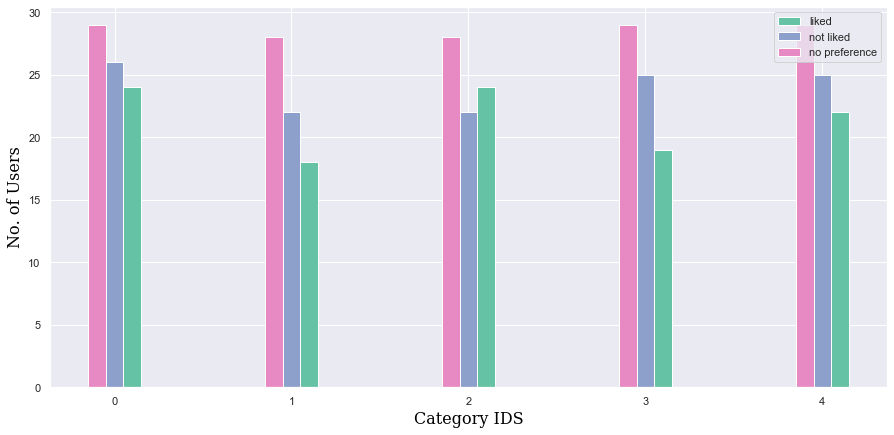

In [224]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.set_xlabel("Category IDS",fontdict=font)
ax.set_ylabel("No. of Users",fontdict=font)
ax.bar(cat_ids1, liked, width=0.1, color=clist[0], align='center',label="liked")
ax.bar(category_ids, not_liked, width=0.1, color=c_list[6], align='center',label="not liked")
ax.bar(cat_ids2, no_pref, width=0.1, color=c_list[10], align='center',label="no preference")
plt.legend()

## Choosing the value of K (# of features)

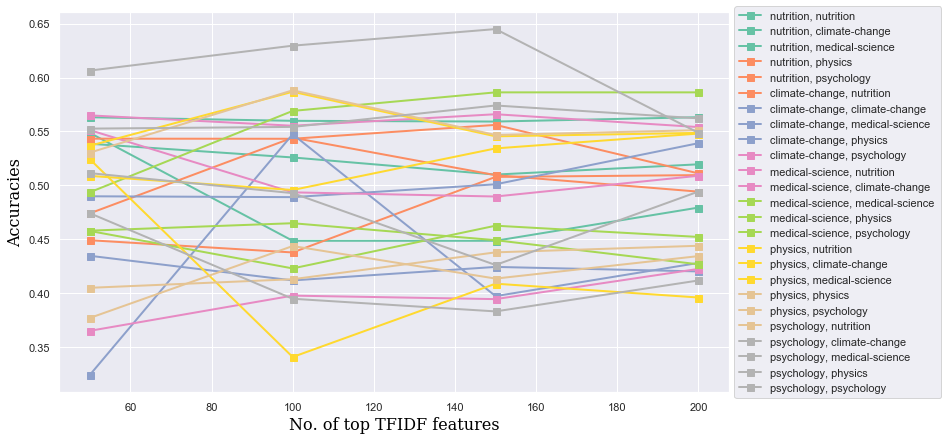

In [180]:
K_features = [50,100,150,200,None]

fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)

ax.set_xlabel("No. of top TFIDF features",fontdict=font)
ax.set_ylabel("Accuracies",fontdict=font)

count=0
for key,value in K_acc_dict.items():
    
    label = rev_cat_map[int(key[0])] + ", " + rev_cat_map[int(key[1])]
    ax.plot(K_features,value,label='%s ' % label, color=clist[count], marker="s",linewidth="2",markersize="7")
    box = ax.get_position()
    count+=1
    
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## Choosing the value of K_friends

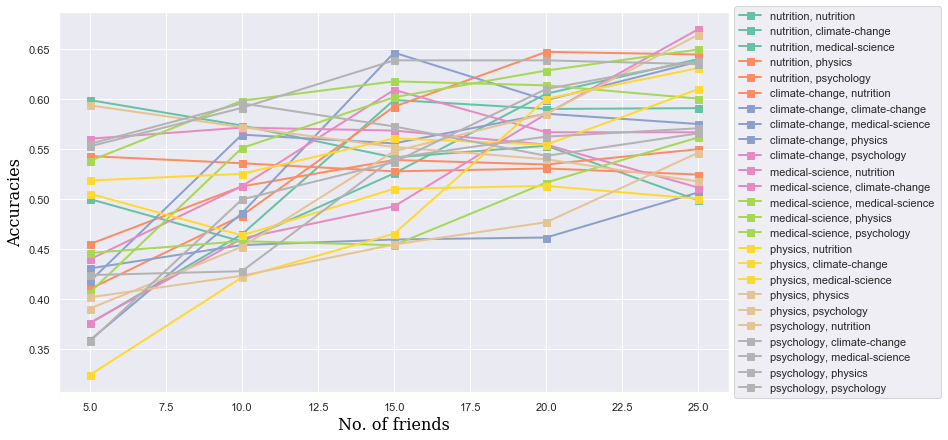

In [156]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)

ax.set_xlabel("No. of friends",fontdict=font)
ax.set_ylabel("Accuracies",fontdict=font)

count=0
for key,value in K_acc_dict.items():
    
    label = rev_cat_map[int(key[0])] + ", " + rev_cat_map[int(key[1])]
    ax.plot(K_list,value,label='%s ' % label, color=clist[count], marker="s",linewidth="2",markersize="7")
    box = ax.get_position()
    count+=1
    
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

